In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import GlobalAveragePooling1D
import yfinance as yf

In [ ]:
data = yf.download('BTC-USD', start="2014-09-17", end="2024-05-17")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
print(data.head(5))
print("------------------------------------------------------------------")
print(data.shape)
print(type(data))

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  
------------------------------------------------------------------
(3530, 6)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(data.tail(5))

                    Open          High           Low         Close  \
Date                                                                 
2024-05-12  60793.503906  61818.156250  60632.601562  61448.394531   
2024-05-13  61451.218750  63422.660156  60769.839844  62901.449219   
2024-05-14  62900.773438  63092.125000  61123.765625  61552.789062   
2024-05-15  61553.988281  66454.453125  61330.410156  66267.492188   
2024-05-16  66256.109375  66712.429688  64613.054688  65231.582031   

               Adj Close       Volume  
Date                                   
2024-05-12  61448.394531  13800459405  
2024-05-13  62901.449219  27889181179  
2024-05-14  61552.789062  28186271527  
2024-05-15  66267.492188  39815167074  
2024-05-16  65231.582031  31573077994  


<Axes: title={'center': 'Bitcoin Close stock plot'}, xlabel='Date'>

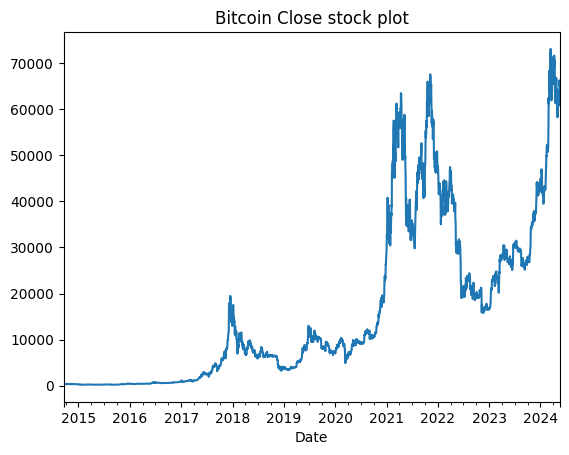

In [ ]:
data['Close'].plot(title='Bitcoin Close stock plot')

In [ ]:
data[['High', 'Low', 'Close']].values

array([[  468.17401123,   452.42199707,   457.33401489],
       [  456.85998535,   413.10400391,   424.44000244],
       [  427.83499146,   384.53201294,   394.79598999],
       ...,
       [63092.125     , 61123.765625  , 61552.7890625 ],
       [66454.453125  , 61330.41015625, 66267.4921875 ],
       [66712.4296875 , 64613.0546875 , 65231.58203125]])

In [ ]:
scaler = MinMaxScaler()
#data_scaled = scaler.fit_transform(data[['High', 'Low', 'Close']].values)

In [ ]:
#train_size = int(len(data)*0.90)
#test_size = len(data)-train_size
test_size = 59
train_size = len(data) - test_size
print(train_size)
print(test_size)

3471
59


In [ ]:
data = data[['High', 'Low', 'Close']].values

In [ ]:
train_data = scaler.fit_transform(data[0:train_size,:])
test_data=scaler.transform(data[train_size:,:])
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (3471, 3)
test_data:  (59, 3)


In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), :])
        dataY.append(dataset[i + time_step, :])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 30
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", x_test.shape)
print("y_test", y_test.shape)

X_train:  (3441, 30, 3)
y_train:  (3441, 3)
X_test:  (29, 30, 3)
y_test (29, 3)


In [ ]:
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 3) #sample, time step, features
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 3)
print("X_train: ", x_train.shape)
print("X_test: ", x_test.shape)

X_train:  (3441, 30, 3)
X_test:  (29, 30, 3)


In [ ]:
x_train.shape[1]

30

In [ ]:
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(128, activation='gelu', dropout=0.0, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(64, activation='gelu', dropout=0.2))
    #model.add(LSTM(128,
    #                activation="gelu",
    #                recurrent_activation="sigmoid",
    #                use_bias=True,
    #                dropout=0.0,
    #                return_sequences=True,
    #                name="LSTM-1",
    #                input_shape=(x_train.shape[1], x_train.shape[2])))  # Ensure x_train is passed as an argument
    #model.add(LSTM(64,
    #                activation='gelu',
    #                recurrent_activation='sigmoid',
    #                use_bias=True,
    #                dropout=0.2,
    #                return_sequences=True,
    #                name="LSTM-2"))
    #model.add(GlobalAveragePooling1D())
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(3))
    return model

In [ ]:
model = create_lstm_model()
model.summary()
model.compile(optimizer='adam',
    loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 128)           67584     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 123,331
Trainable params: 123,331
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_filepath = 'model_{epoch}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_loss',
    mode='min',
    save_best_only=True
)

model_earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 10,
    verbose = 1, #shows message whnen callback takes an action
    mode = 'min',
    restore_best_weights = True
)

history = model.fit(x_train,
    y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=100,
    verbose=1,
    callbacks = [model_checkpoint_callback])

Epoch 1/100
108/108 [==============================] - 18s 111ms/step - loss: 0.0136 - val_loss: 0.0012
Epoch 2/100
108/108 [==============================] - 10s 93ms/step - loss: 8.3173e-04 - val_loss: 0.0029
Epoch 3/100
108/108 [==============================] - 11s 106ms/step - loss: 7.7080e-04 - val_loss: 0.0013
Epoch 4/100
108/108 [==============================] - 13s 122ms/step - loss: 7.1467e-04 - val_loss: 8.9023e-04
Epoch 5/100
108/108 [==============================] - 11s 106ms/step - loss: 6.6378e-04 - val_loss: 0.0012
Epoch 6/100
108/108 [==============================] - 12s 113ms/step - loss: 6.2923e-04 - val_loss: 0.0042
Epoch 7/100
108/108 [==============================] - 10s 93ms/step - loss: 5.5767e-04 - val_loss: 0.0077
Epoch 8/100
108/108 [==============================] - 11s 98ms/step - loss: 5.2417e-04 - val_loss: 0.0062
Epoch 9/100
108/108 [==============================] - 11s 103ms/step - loss: 5.1203e-04 - val_loss: 0.0012
Epoch 10/100
108/108 [=========

In [ ]:
model.save("model.keras")

In [ ]:
training_prediction = model.predict(x_train)
test_prediction = model.predict(x_test)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
training_prediction = scaler.inverse_transform(training_prediction)
test_prediction = scaler.inverse_transform(test_prediction)

In [ ]:
train_score = np.sqrt(mean_squared_error(y_train, training_prediction))
print(train_score)

In [ ]:
test_score = np.sqrt(mean_squared_error(y_test, test_prediction))
print(test_score)

In [ ]:
#r-2 score
train_r2 = r2_score(training_prediction, y_train)
print(train_r2)
test_r2 = r2_score(test_prediction, y_test)
print(test_r2)

0.9969262789100979
0.9908278410775141


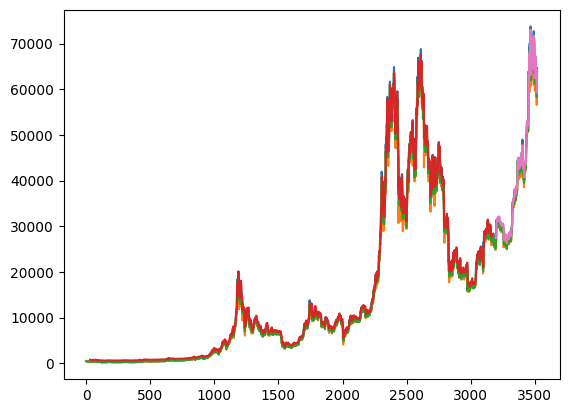

In [ ]:
### Plotting
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(training_prediction)+look_back, 0] = training_prediction[:,0]
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(training_prediction)+(look_back*2):len(data_scaled), 0] = test_prediction[:,0]
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-30,63839.417969,64703.332031,59120.066406,60636.855469,60636.855469,37840840057
2024-05-01,60609.496094,60780.500000,56555.292969,58254.011719,58254.011719,48439780271
2024-05-02,58253.703125,59602.296875,56937.203125,59123.433594,59123.433594,32711813559
2024-05-03,59122.300781,63320.503906,58848.312500,62889.835938,62889.835938,33172023048
2024-05-04,62891.031250,64494.957031,62599.351562,63891.472656,63891.472656,20620477992


In [ ]:
input = np.array(x_test[-1:])
pred = model.predict(input)
input = np.append(np.delete(input, 0, axis=1), [pred], axis=1)

future_pred = []

for i in range(0,7):
    pred = model.predict(input)
    input = np.append(np.delete(input, 0, axis=1), [pred], axis=1)
    pred_unscaled = scaler.inverse_transform(pred)
    future_pred.append(pred_unscaled[0])
future_pred = np.array(future_pred)

1/1 [==============================] - 0s 50ms/step


In [ ]:
future_pred

array([[62342.67 , 58618.207, 60692.848],
       [61218.438, 57445.977, 59572.37 ],
       [60238.02 , 56460.28 , 58601.43 ],
       [59391.445, 55636.53 , 57768.96 ],
       [58656.48 , 54939.496, 57051.086],
       [58003.977, 54331.223, 56417.32 ],
       [57409.08 , 53781.75 , 55841.82 ]], dtype=float32)

In [ ]:
print("High: " + str(int(np.max(future_pred[:,0]))))
print("Low: " + str(int(np.min(future_pred[:,1]))))
print("Average Closing Price: " + str(int(np.mean(future_pred[:,2]))))

High: 62342
Low: 53781
Average Closing Price: 57992
